# Movie analysis

In this notebook, we are exploring/learning how to play around and visualize data using Jupyter. I decided to work with seaborn just to get a baseline understanding.

I selected the imdb_superhero dataset. There is a lot of generalizing that needs to be done have our categorical variables mean something. We can note the mapping exercise cleaning up our ratings.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import re
# import math
import numpy as np
import pymongo
import pprint
import json

In [23]:
filename = r"C:\repos\auth.json"

with open(filename) as f:
    data = json.load(f)
    mongo_conn_st = data['mongodb3']

client = pymongo.MongoClient(mongo_conn_st, authSource='mongodb')
db = client.movies  # was admin
serv_stat_resp= db.command('serverStatus')
print(pprint.pprint(serv_stat_resp))

{'$clusterTime': {'clusterTime': Timestamp(1652540441, 19),
                  'signature': {'hash': b'\x15l\x83Q\xa3\xae`Z\x1b\xec\x04\xb4'
                                        b'E \x95\xa5"G\xf4u',
                                'keyId': 7039397328800710670}},
 'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 0, 'warning': 0},
 'atlasVersion': {'gitVersion': '43d346b322f8928db550aae247d48b27a4d47d3c',
                  'version': '20220420.0.0.1650048530'},
 'connections': {'available': 481, 'current': 19, 'totalCreated': 320},
 'extra_info': {'note': 'fields vary by platform', 'page_faults': 0},
 'host': 'cluster0-shard-00-02.t7mgw.mongodb.net:27017',
 'localTime': datetime.datetime(2022, 5, 14, 15, 0, 41, 682000),
 'mem': {'bits': 64,
         'mapped': 0,
         'mappedWithJournal': 0,
         'resident': 0,
         'supported': True,
         'virtual': 0},
 'metrics': {'aggStageCounters': {'search': 0,
                                  'searchBeta': 0,
        

In [24]:
# 
cursor = db['imdb_superheroes'].find({})

movie_df = pd.DataFrame(list(cursor))
movie_df.head()

,_id,ID,Title,Runtime,Rating,Votes,MPAARating,ReleaseYear,ReleaseMonth,ReleaseDay,...,Producer5,Company1,Company2,Company3,Director2,Company4,Company5,Director3,Director4,Director5
0,627fc3f1a499847d5c32ba34,6320628,Spider-Man: Far from Home,129.0,7.7,200908.0,PG-13,2019,6,26,...,Louis D'Esposito,Columbia Pictures,Pascal Pictures,Marvel Studios,NaN,NaN,NaN,NaN,NaN,NaN
1,627fc3f1a499847d5c32ba35,4154796,Avengers: Endgame,181.0,8.6,569782.0,PG-13,2019,4,22,...,Jon Favreau,Marvel Studios,NaN,NaN,Joe Russo,NaN,NaN,NaN,NaN,NaN
2,627fc3f1a499847d5c32ba36,6565702,Dark Phoenix,113.0,5.8,96585.0,PG-13,2019,6,5,...,Stan Lee,Twentieth Century Fox,Bad Hat Harry Productions,Donners' Company,NaN,Kinberg Genre,Marvel Entertainment,NaN,NaN,NaN
3,627fc3f1a499847d5c32ba37,468569,The Dark Knight,152.0,9.0,2105721.0,TV-14::(LV),2008,7,14,...,Christopher Nolan,Warner Bros.,Legendary Entertainment,Syncopy,NaN,DC Comics,NaN,NaN,NaN,NaN
4,627fc3f1a499847d5c32ba38,1477834,Aquaman,143.0,7.0,300580.0,PG-13,2018,11,26,...,Geoff Johns,DC Comics,DC Entertainment,Panoramic Pictures,NaN,Rodeo FX,The Safran Company,NaN,NaN,NaN


In [25]:
# import superhero movies
# movie_df = pd.read_csv('../data/imdb_superhero.csv')
# movie_df

## Cleansing the data

In [26]:
# create dictionary to append unique ratings for cleansing
rating_map = {
    "MPAARating": [],
    "SimpleRating": []
}

# iterate through all unique ratings in dataset
for rating in movie_df['MPAARating'].unique():
    # set inital rating in dataframe
    rating_map["MPAARating"].append(rating)
    try:
        # split at common delimiter
        rating_map["SimpleRating"].append(rating.split(":")[0])
    # null values return an error, set as unrated
    except AttributeError:
        rating_map["SimpleRating"].append("Unrated")

# convert to dataframe for merging
ratemap_df = pd.DataFrame(rating_map)
# merge dataframes
movie_df = pd.merge(left=movie_df, right=ratemap_df, how="left", on='MPAARating')
# normalizing the budgets as there is a strong skew
movie_df["Budg_Transf"] = np.log10(movie_df['Budget'])
# output
movie_df

,_id,ID,Title,Runtime,Rating,Votes,MPAARating,ReleaseYear,ReleaseMonth,ReleaseDay,...,Company2,Company3,Director2,Company4,Company5,Director3,Director4,Director5,SimpleRating,Budg_Transf
0,627fc3f1a499847d5c32ba34,6320628,Spider-Man: Far from Home,129.0,7.7,200908.0,PG-13,2019,6,26,...,Pascal Pictures,Marvel Studios,NaN,NaN,NaN,NaN,NaN,NaN,PG-13,8.204120
1,627fc3f1a499847d5c32ba35,4154796,Avengers: Endgame,181.0,8.6,569782.0,PG-13,2019,4,22,...,NaN,NaN,Joe Russo,NaN,NaN,NaN,NaN,NaN,PG-13,8.551450
2,627fc3f1a499847d5c32ba36,6565702,Dark Phoenix,113.0,5.8,96585.0,PG-13,2019,6,5,...,Bad Hat Harry Productions,Donners' Company,NaN,Kinberg Genre,Marvel Entertainment,NaN,NaN,NaN,PG-13,8.301030
3,627fc3f1a499847d5c32ba37,468569,The Dark Knight,152.0,9.0,2105721.0,TV-14::(LV),2008,7,14,...,Legendary Entertainment,Syncopy,NaN,DC Comics,NaN,NaN,NaN,NaN,TV-14,8.267172
4,627fc3f1a499847d5c32ba38,1477834,Aquaman,143.0,7.0,300580.0,PG-13,2018,11,26,...,DC Entertainment,Panoramic Pictures,NaN,Rodeo FX,The Safran Company,NaN,NaN,NaN,PG-13,8.204120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,627fc3f1a499847d5c32bc13,1396235,Catalina: A New Kind of Superhero,98.0,3.0,14.0,Not Rated,2009,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,3.230449
480,627fc3f1a499847d5c32bc14,2597794,ACT Honour Walk,50.0,NaN,NaN,NaN,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,NaN
481,627fc3f1a499847d5c32bc15,4306404,Oigye Eseo on Ulemae 9: Mujeok Ui Paiteo Ulemae,NaN,NaN,NaN,NaN,1993,10,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,NaN
482,627fc3f1a499847d5c32bc16,5737002,Translyatsia Safronova: Pro Konstruktory,65.0,1.2,12.0,NaN,2015,8,19,...,Obzor konstruktora,NaN,Konstantin Safronov,NaN,NaN,NaN,NaN,NaN,Unrated,NaN


## Exploring the data

In [27]:
# validating changes
movie_df.SimpleRating.unique()

array(['PG-13', 'TV-14', 'PG', 'R', 'TV-PG', 'TV-G', 'TV-Y7', 'Unrated',
       'Not Rated', 'TV-MA', 'G'], dtype=object)

In [28]:
# movie_df.sort_values(by='Votes', ascending=False)

<AxesSubplot:>

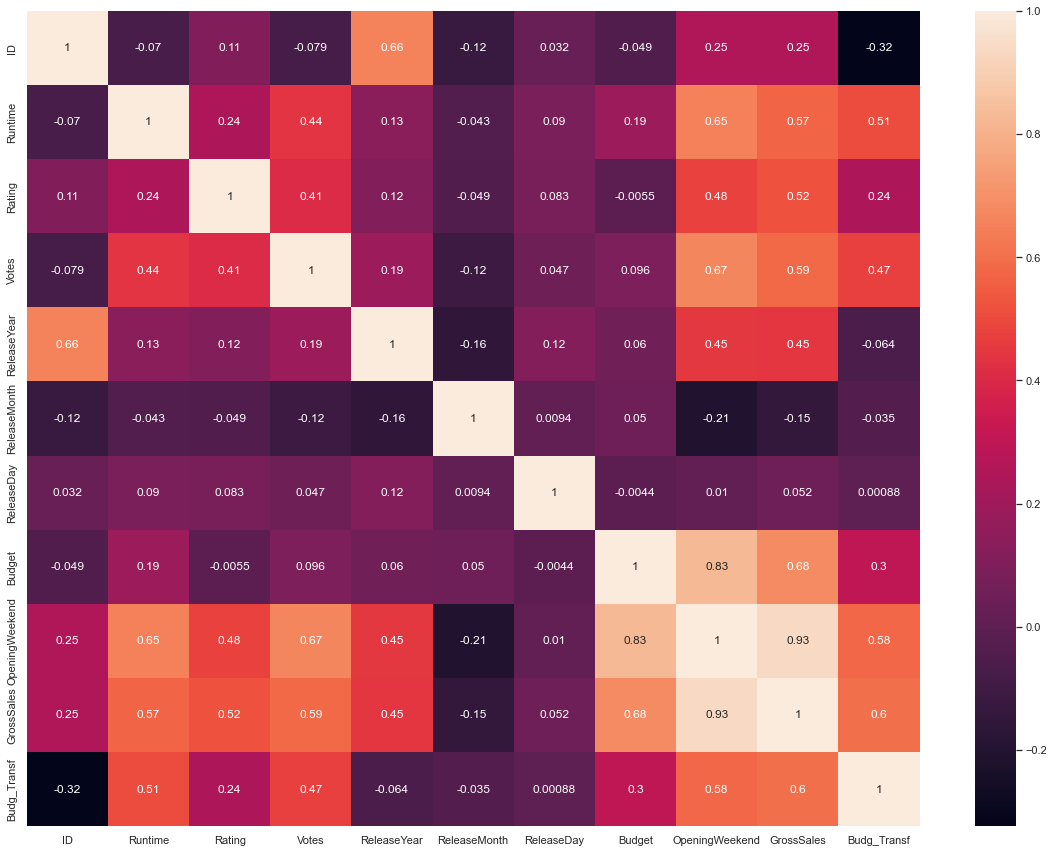

In [29]:
# set the canvas size
sns.set(rc={"figure.figsize":(20, 15)})

# do heatmap of correlations
sns.heatmap(movie_df.corr(), annot=True)

We can see there is a strong relationship between  OpeningWeekend and GrossSales. Another meaningful relationship appears to be OpeningWeekend and Budget. 

In [30]:
# show all columns to make it easier to copy/paste
movie_df.columns

Index(['_id', 'ID', 'Title', 'Runtime', 'Rating', 'Votes', 'MPAARating',
       'ReleaseYear', 'ReleaseMonth', 'ReleaseDay', 'Budget', 'OpeningWeekend',
       'GrossSales', 'Genres', 'Cast1', 'Cast2', 'Cast3', 'Cast4', 'Cast5',
       'Cast6', 'Cast7', 'Cast8', 'Cast9', 'Cast10', 'Director1', 'Producer1',
       'Producer2', 'Producer3', 'Producer4', 'Producer5', 'Company1',
       'Company2', 'Company3', 'Director2', 'Company4', 'Company5',
       'Director3', 'Director4', 'Director5', 'SimpleRating', 'Budg_Transf'],
      dtype='object')

## Visualizing the data

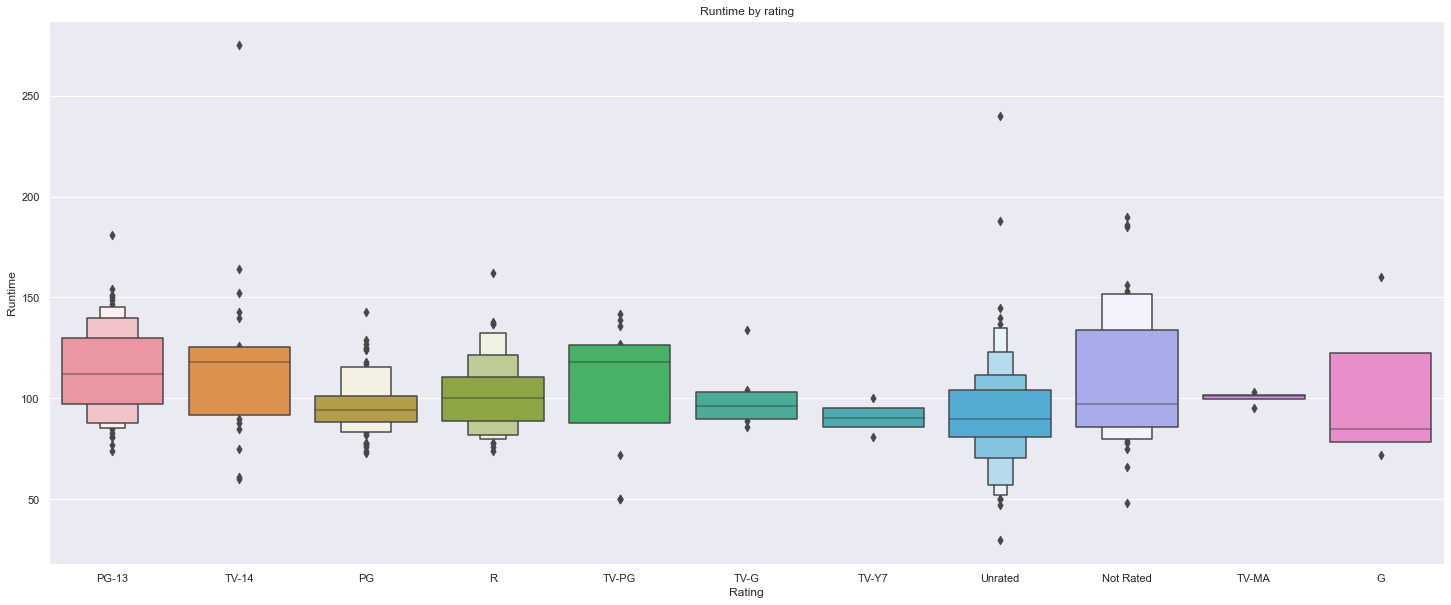

In [31]:
# boxplot looking at spread of runtime by rating
sns.set(rc={"figure.figsize":(25, 10)})
sns.boxenplot(data=movie_df, x="SimpleRating", y="Runtime")

plt.title('Runtime by rating')
plt.xlabel('Rating')
plt.ylabel('Runtime')

plt.show()

We can observe many outliers through our ratings, with some strong centers. PG is a great example, whereas Unrated shows significant spread. PG-13 looks most normal, with outliers

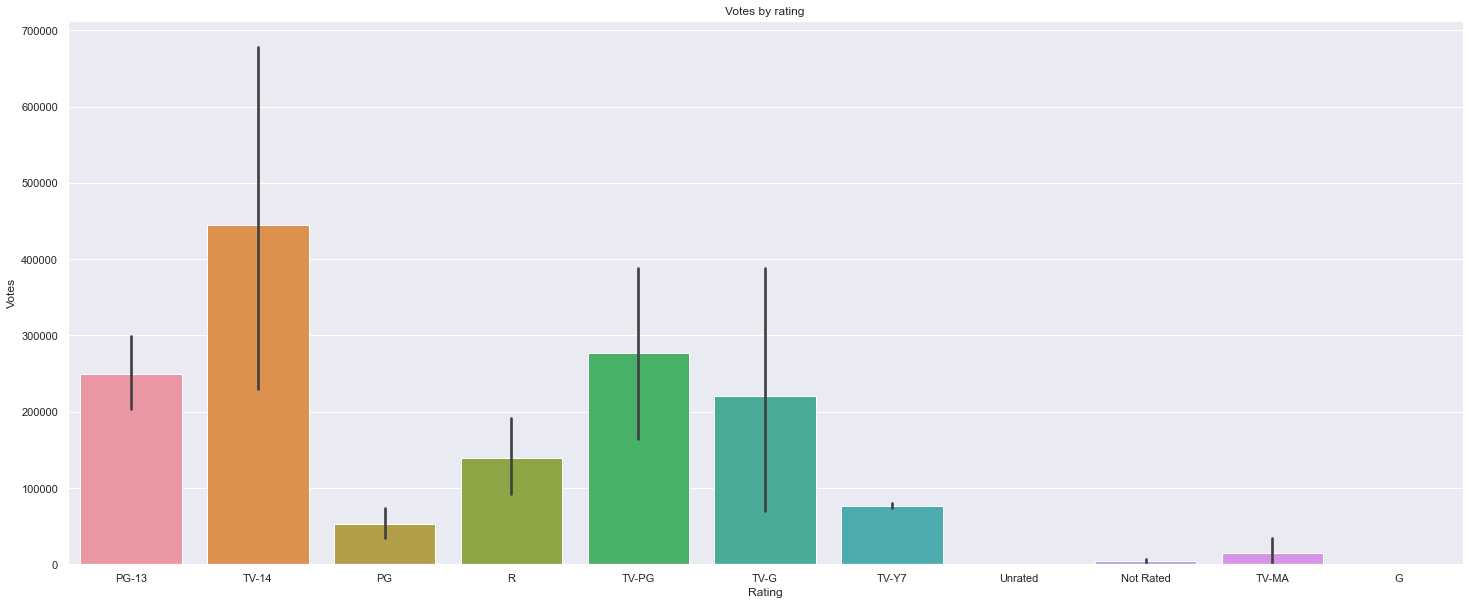

In [32]:
# show barplot of ratings and votes
sns.set(rc={"figure.figsize":(25, 10)})
sns.barplot(data=movie_df, x="SimpleRating", y="Votes")

plt.title('Votes by rating')
plt.xlabel('Rating')
plt.ylabel('Votes')

plt.show()

We can really see how popular TV-14 is by votes alone. PG-13 is also strong, almost equal to that of TV-PG. This leads me to question whether voters have a preference for non-Adult-rated media (TV-MA, R)

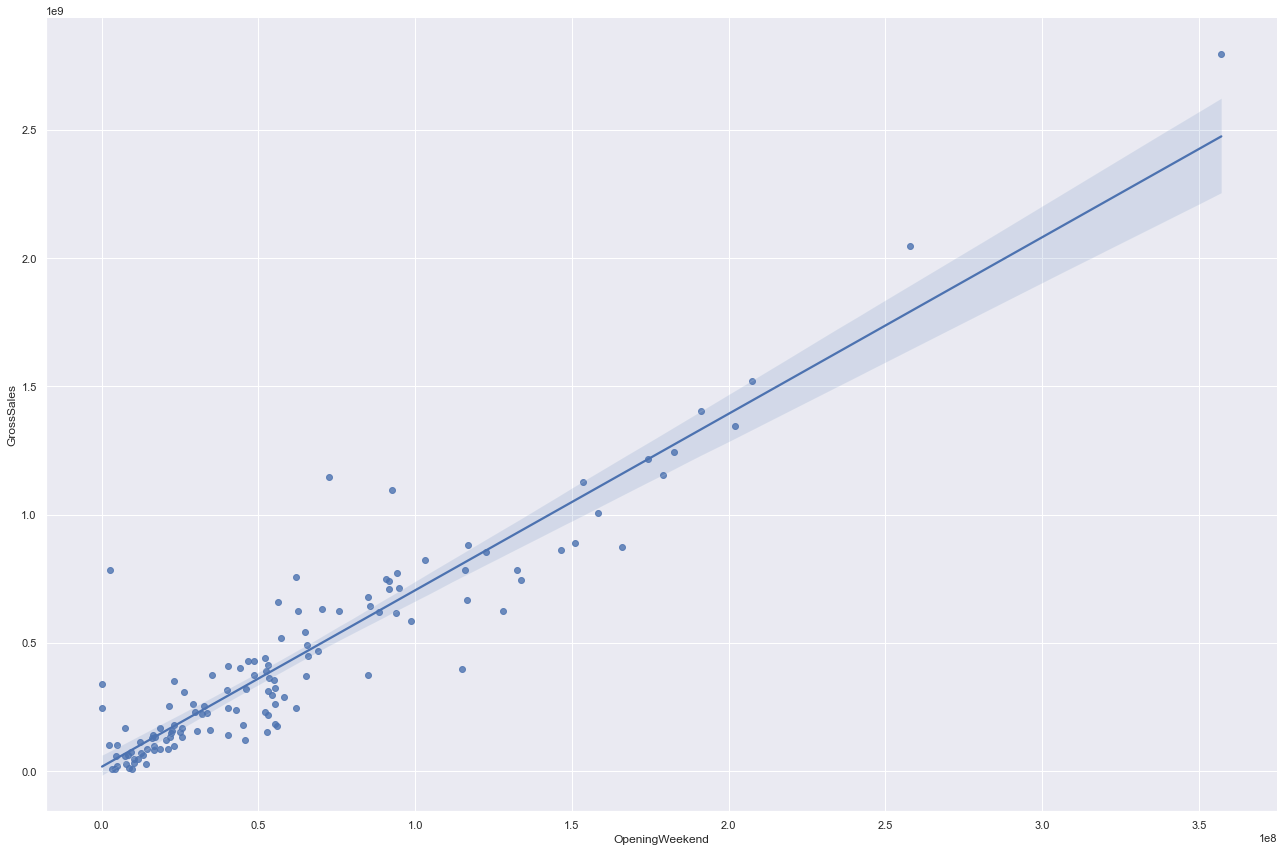

In [33]:
# create lineplot looking at observations between opening weekend and sales
# height replaces sns.set when available
sns.lmplot(x="OpeningWeekend", y="GrossSales", data=movie_df, height=12, aspect=1.5)

This graph shows that strong correlation we noted above in our correlation chart (0.93). I would like to add that to this chart!

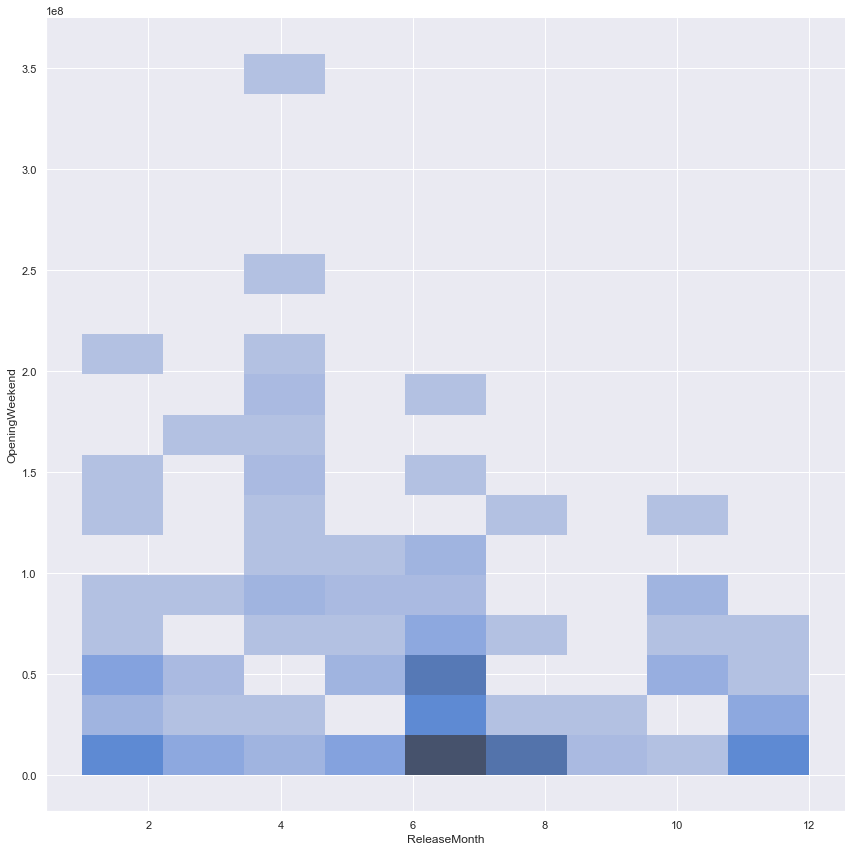

In [34]:
# create a distribution plot by release month
sns.displot(x="ReleaseMonth", y="OpeningWeekend", data=movie_df, height=12)

Playing around using ctrl+shift, I found this plot. I liked how it showed the density of where our data is by opening weekend sales by month. We can see just how strong of a month June is for movies. it makes sense being the beginning of summer!


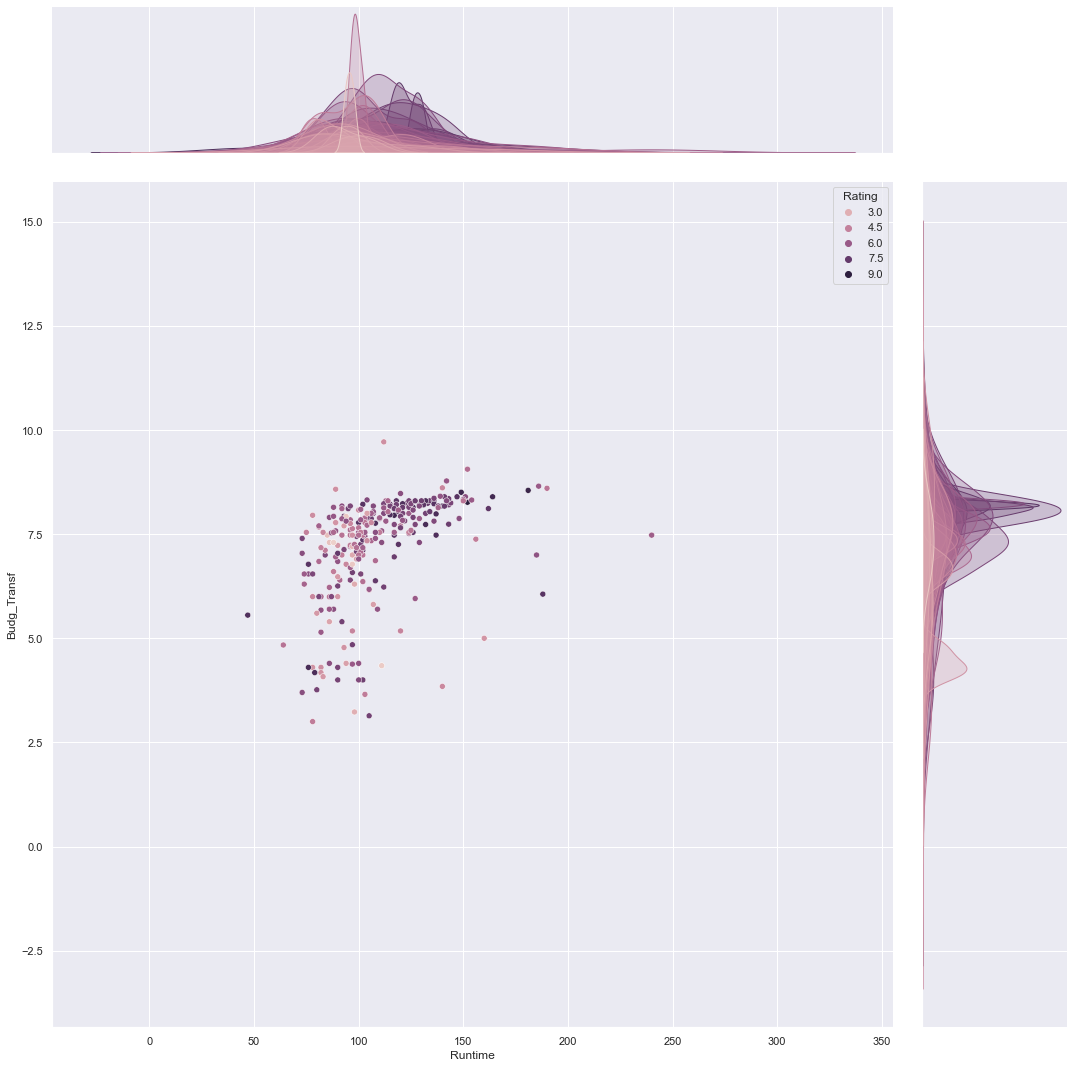

In [35]:
sns.jointplot(data=movie_df, x="Runtime", y="Budg_Transf", hue="Rating", height=15, dropna=True)

I found a similar example online, but what I wanted to see was how well my transformed budget values compared to the runtime. We had a calculated correlation of 0.51 and this looks about right!

This is a great tool to partner with a correlation heatmap. The kernal density estimate plots are handsdown some of my favorite ways to vizualize data. I see this really helpful when needing to identify block designs when needed as well.

# Conclusion

Ultimately, this dataset made me want to continue honing my skills on cleansing data efficiently. I'm glad I did this by rating, as the analysis felt a bit more meaningful. I would like to next determine whether or not there are meaningful differences among ratings by rating.

I actually got rid of some analysis regarding sales by release month. I learned September was not a good month for movies!

### Extras

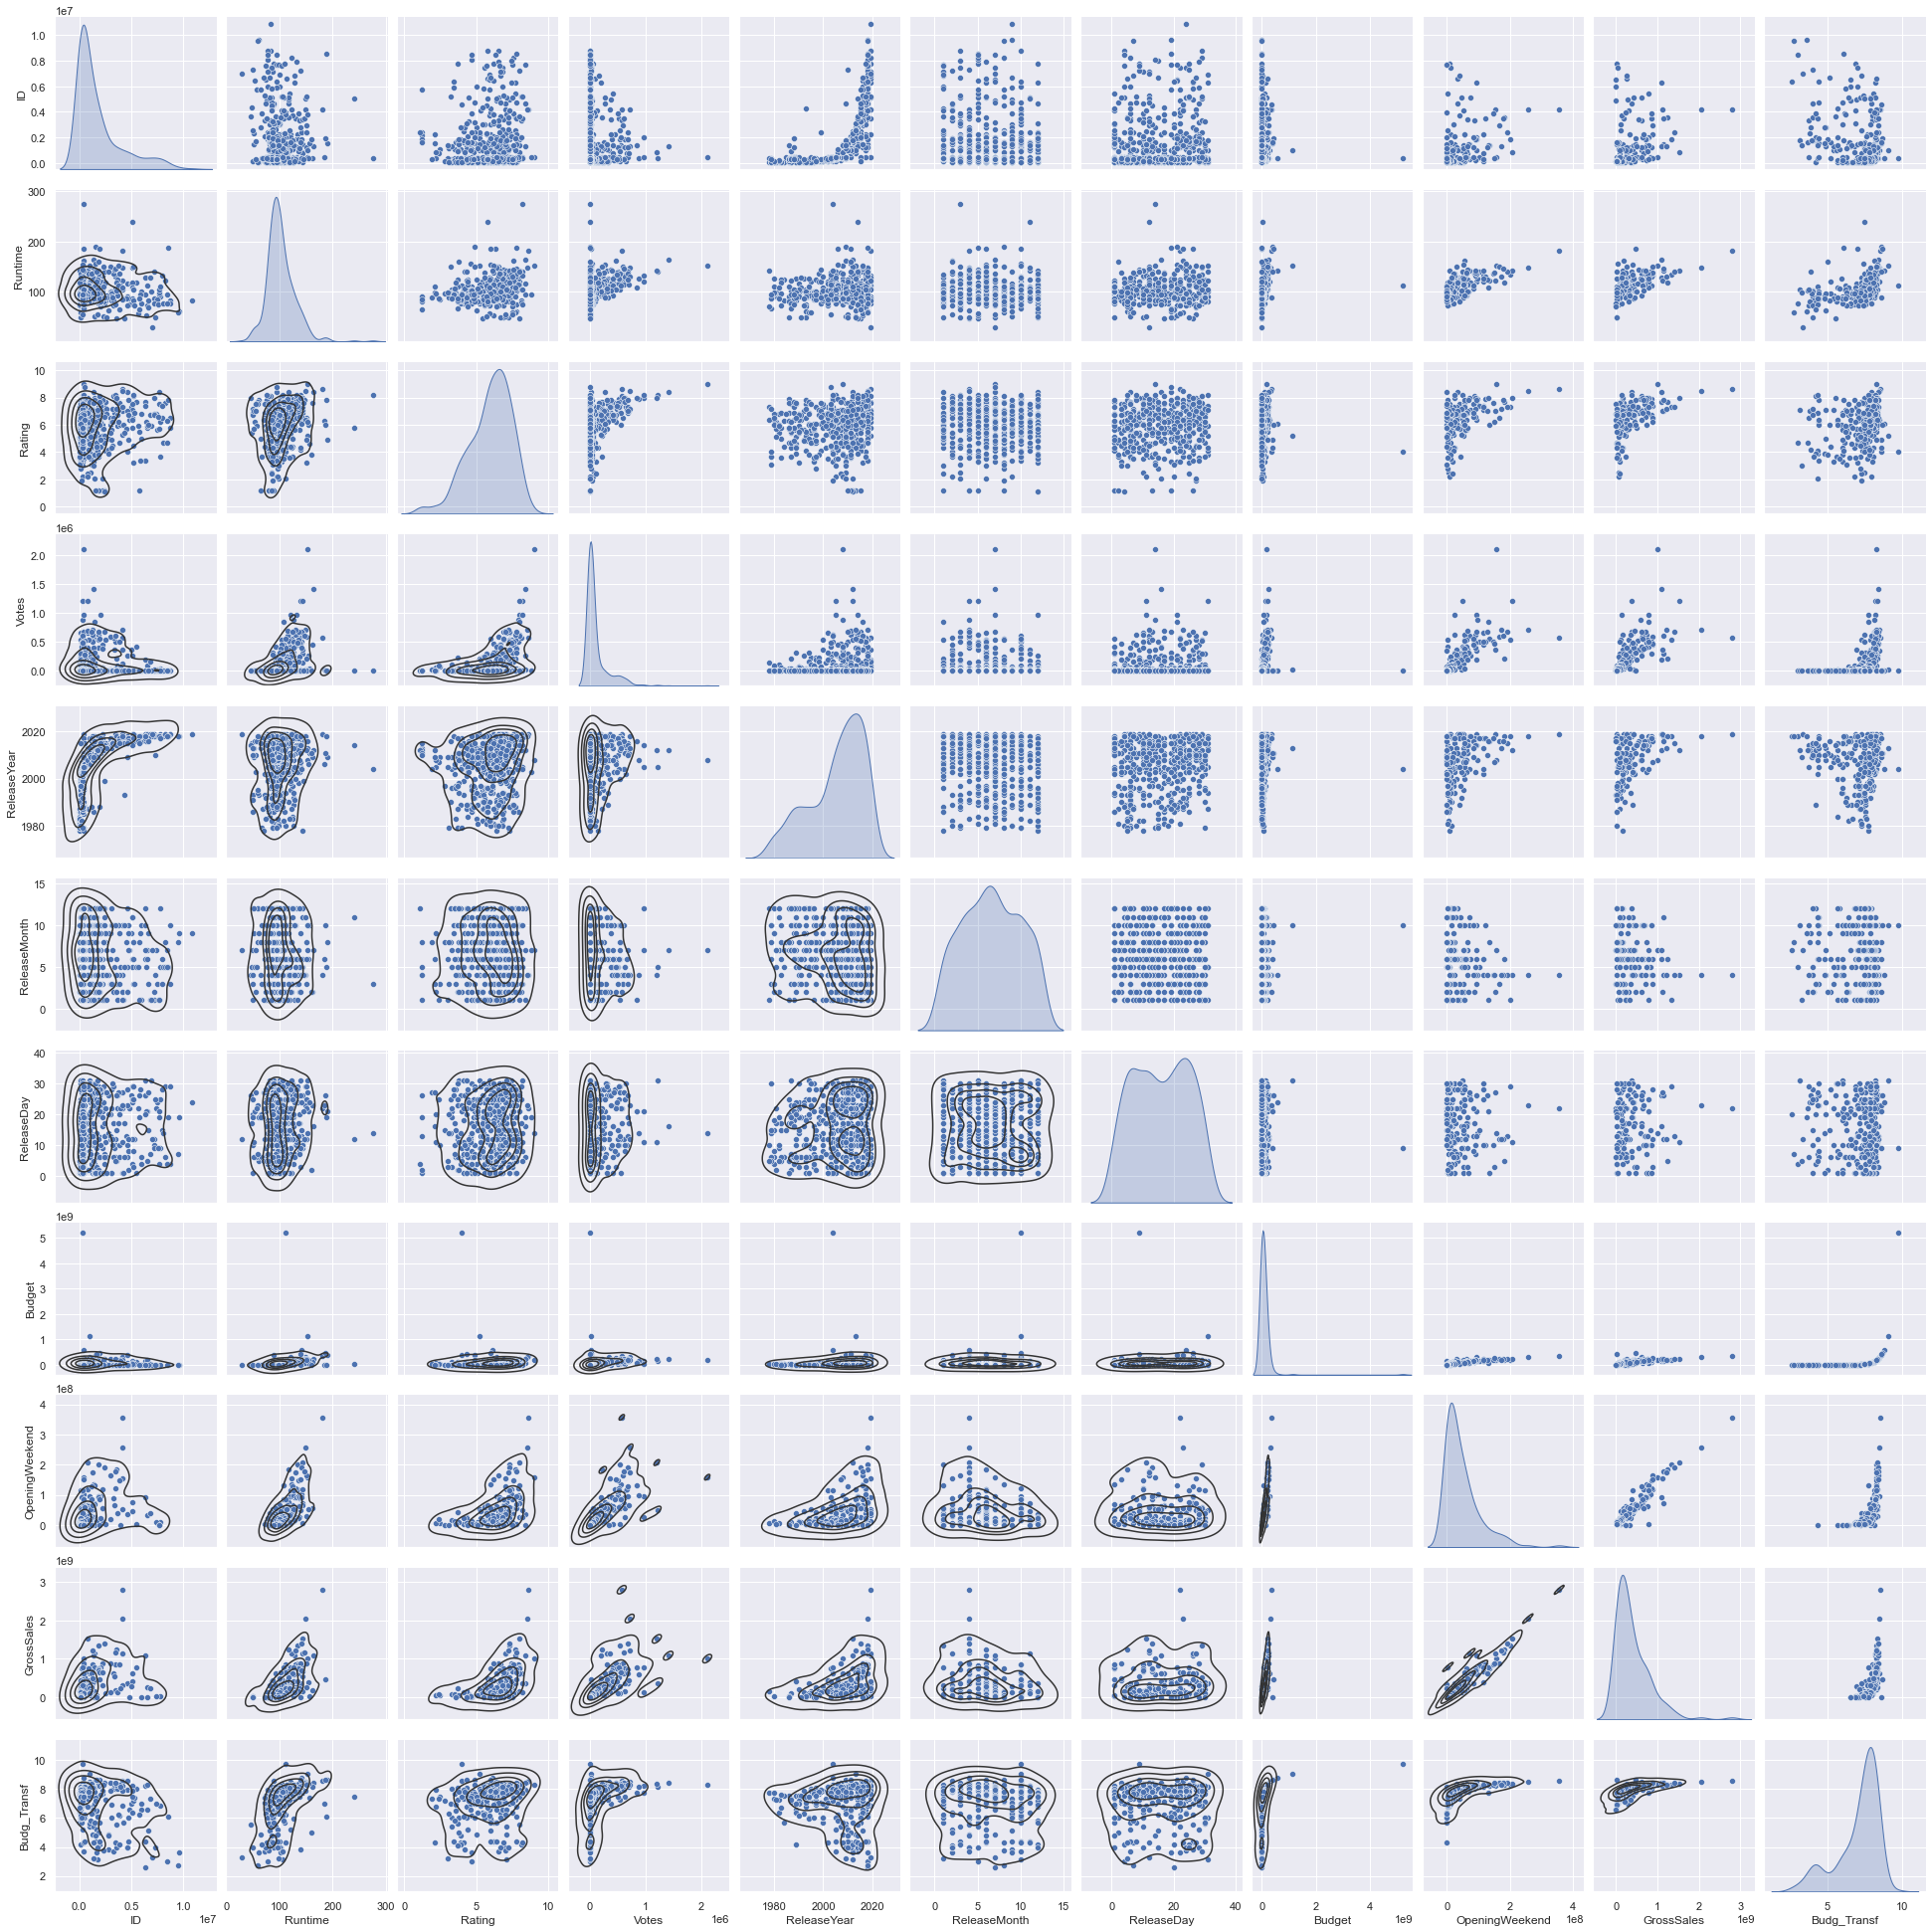

In [36]:
# create a pairplot of values and use the kernal density estimate plot - a "topographic" view of how dense our data is clustered/spread
g = sns.pairplot(movie_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=5, color=".2")

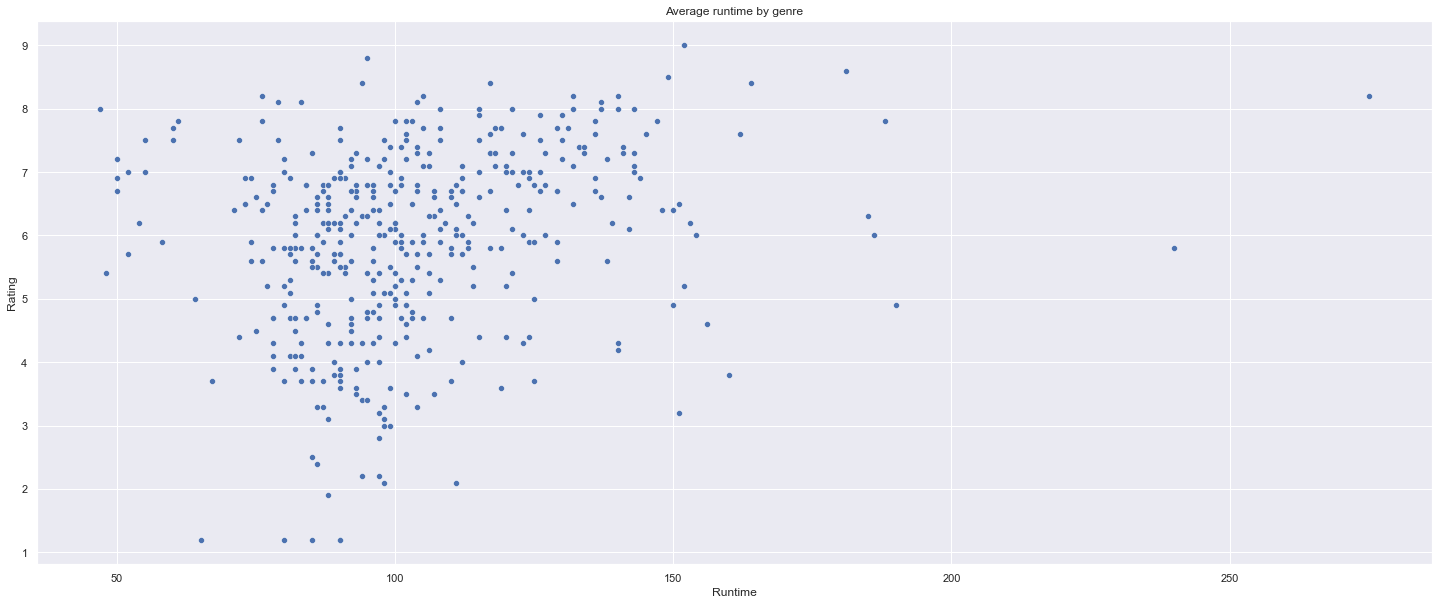

In [37]:
plt.figure(figsize=(25,10))

sns.scatterplot(data=movie_df, x="Runtime", y="Rating")

plt.title('Average runtime by genre')
plt.xlabel('Runtime')
plt.ylabel('Rating')

plt.show()

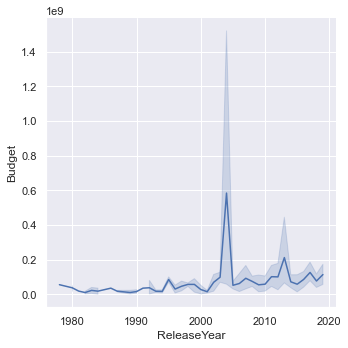

In [38]:
sns.relplot(x="ReleaseYear", y="Budget", kind="line", data=movie_df)

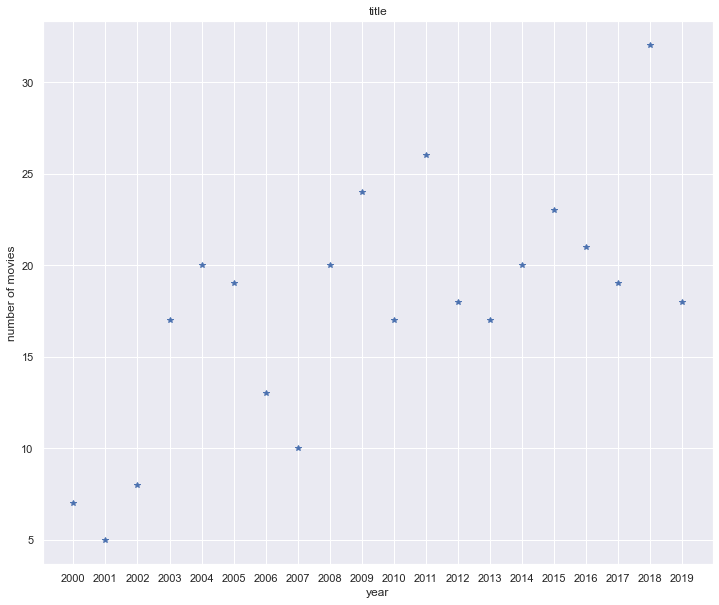

In [39]:
plt.figure(figsize=(12,10))
plt.title('title')
plt.xlabel('year')
plt.ylabel('number of movies')

df = movie_df["ReleaseYear"].groupby(movie_df.ReleaseYear).agg('count').loc[2000:]
plt.xticks(df.keys().to_list())

plt.plot(df, '*')
plt.show()